# Random Forest Model Interpretation

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [3]:
set_plot_sizes(12,14,16)

## Load in our data from last lesson

In [4]:
PATH = '/Users/Vishy/Desktop/FastAi-ML/'

df_raw = pd.read_feather('tmp/bulldozers-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [5]:
nas

{'auctioneerID': 2.0, 'MachineHoursCurrentMeter': 0.0}

In [7]:
df_trn.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,999089,3157,121,3.0,2004,68.0,3,950,296,...,320,False,False,False,False,False,False,1163635200,False,False
1,1139248,117657,77,121,3.0,1996,4640.0,3,1725,527,...,86,False,False,False,False,False,False,1080259200,False,False
2,1139249,434808,7009,121,3.0,2001,2838.0,1,331,110,...,57,False,False,False,False,False,False,1077753600,False,False
3,1139251,1026470,332,121,3.0,2001,3486.0,1,3674,1375,...,139,False,False,False,False,False,False,1305763200,False,False
4,1139253,1057373,17311,121,3.0,2007,722.0,2,4208,1529,...,204,False,False,False,False,False,False,1248307200,False,False


In [9]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [10]:
def rmse(x,y):
    return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [11]:
df_raw.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,Low,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,Low,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,High,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,High,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,Medium,S175,...,23,3,204,False,False,False,False,False,False,1248307200


## Confidence based on tree variance

In [12]:
set_rf_samples(50000)

In [13]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20583043839282386, 0.24851474240075955, 0.9114570424928068, 0.8897058982418762, 0.8944829991416937]


In [14]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 2.3 s, sys: 146 ms, total: 2.45 s
Wall time: 2.83 s


(9.23538379941014, 0.2523519355086017)

In [15]:
def get_preds(t): 
    return t.predict(X_valid)

%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 119 ms, sys: 124 ms, total: 243 ms
Wall time: 1.77 s


(9.23538379941014, 0.2523519355086017)

In [16]:
preds.shape

(40, 12000)

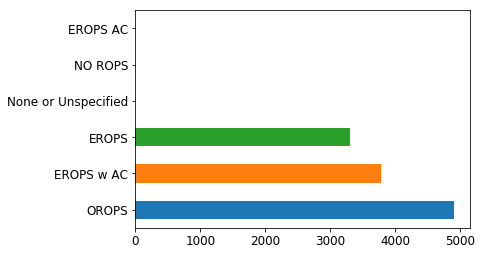

In [17]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

In [18]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.843184,0.271947
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.572110,0.265039
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.684128,0.221700


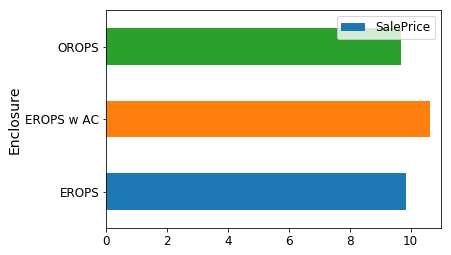

In [19]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

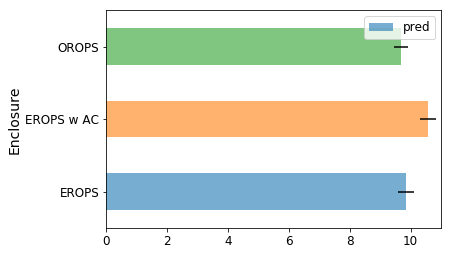

In [20]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));

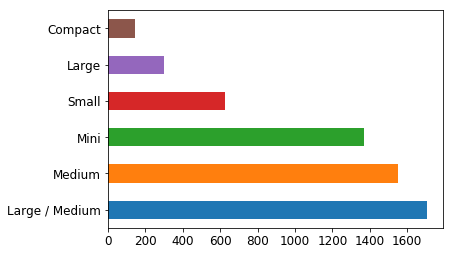

In [21]:
raw_valid.ProductSize.value_counts().plot.barh();

In [22]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.863516,0.346831
Large,10.470589,10.382622,0.359445
Large / Medium,10.691871,10.641901,0.296949
Medium,10.681511,10.620653,0.280309
Mini,9.535147,9.564819,0.249643
Small,10.324448,10.328336,0.305373


In [23]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Compact           0.035163
Large             0.034620
Small             0.029566
Large / Medium    0.027904
Medium            0.026393
Mini              0.026100
dtype: float64

# Feature importance

In [24]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
5,YearMade,0.170416
37,Coupler_System,0.127639
13,ProductSize,0.090624
14,fiProductClassDesc,0.087115
2,ModelID,0.057677
63,saleElapsed,0.051635
10,fiSecondaryDesc,0.045597
19,Enclosure,0.035368
39,Hydraulics_Flow,0.034367
38,Grouser_Tracks,0.031033


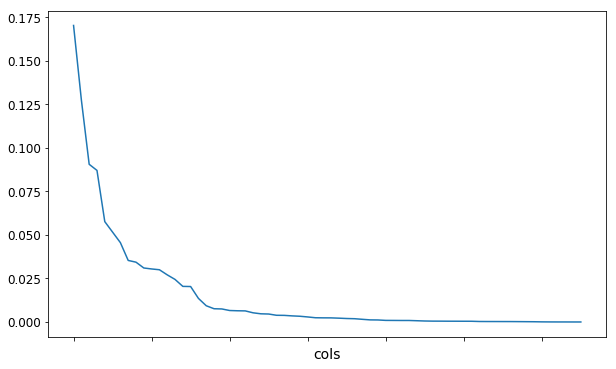

In [25]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [26]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

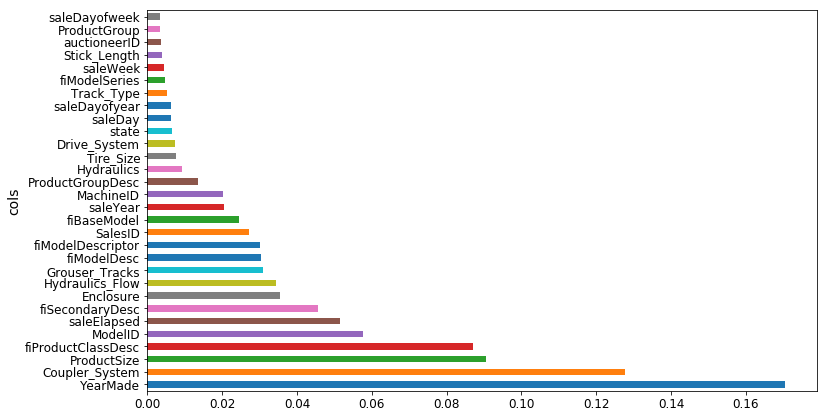

In [27]:
plot_fi(fi[:30]);

In [28]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

24

In [29]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [30]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2066775564480283, 0.24527961859958577, 0.9107267259563967, 0.8925587880986622, 0.894299060673244]


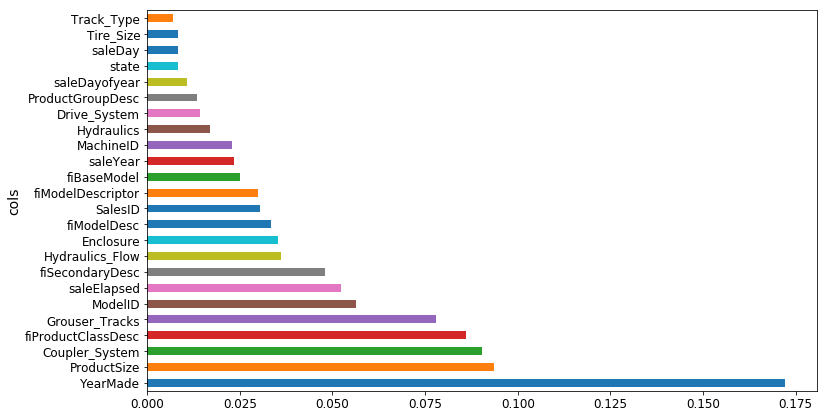

In [31]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

# One-hot encoding

In [32]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20702488795079507, 0.2534130836955467, 0.9104264178272591, 0.8853151525031767, 0.8927201736662794]


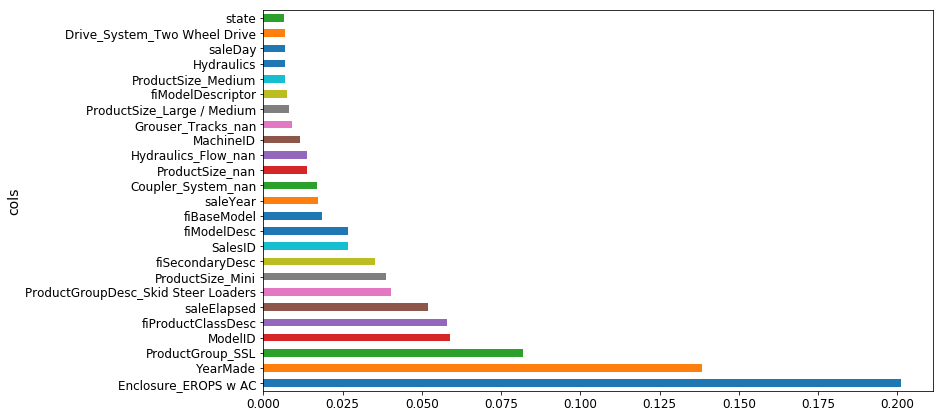

In [33]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

## Removing redundant features

In [34]:
from scipy.cluster import hierarchy as hc

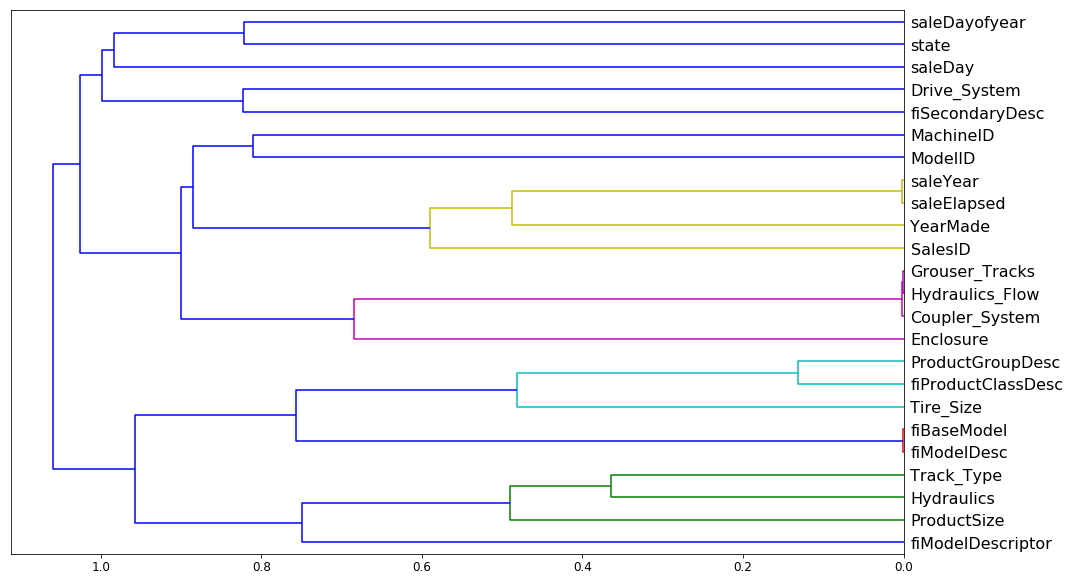

In [35]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [36]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [37]:
get_oob(df_keep)

0.8899076506311667

In [38]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.8895190670845539
saleElapsed 0.8873376621559212
fiModelDesc 0.8885453052722518
fiBaseModel 0.8896259352389846
Grouser_Tracks 0.8899118855466762
Coupler_System 0.8897415694159662


In [39]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.8888334911811657

In [40]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [41]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [42]:
keep_cols = np.load('tmp/keep_cols.npy')
df_keep = df_trn[keep_cols]

In [43]:
reset_rf_samples()

In [44]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1257670772545673, 0.22878974092768473, 0.966942594682497, 0.9065194913041639, 0.9085446926930683]


## Partial dependence

In [48]:
from pdpbox import pdp
from plotnine import *

In [49]:
set_rf_samples(50000)

In [50]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

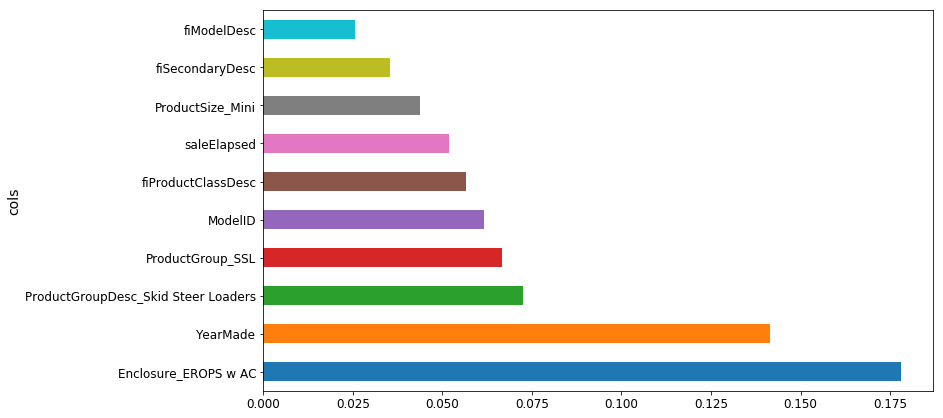

In [51]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

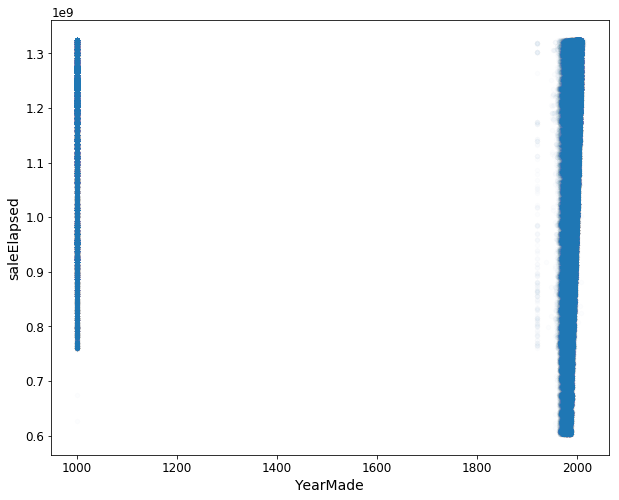

In [52]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

In [53]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)

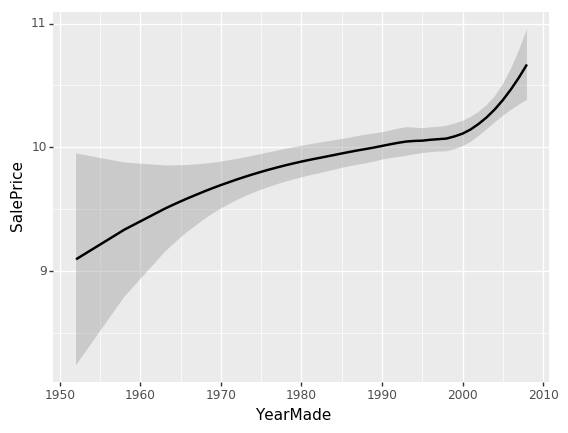

<ggplot: (-9223372029302481639)>

In [55]:
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess')

In [56]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

In [58]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, 
                        cluster=clusters is not None, n_cluster_centers=clusters)

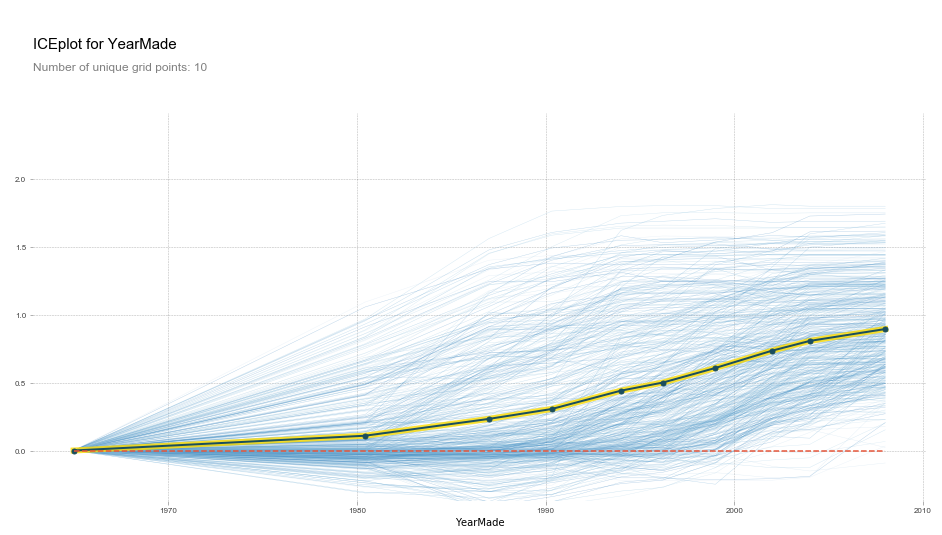

In [59]:
plot_pdp('YearMade')

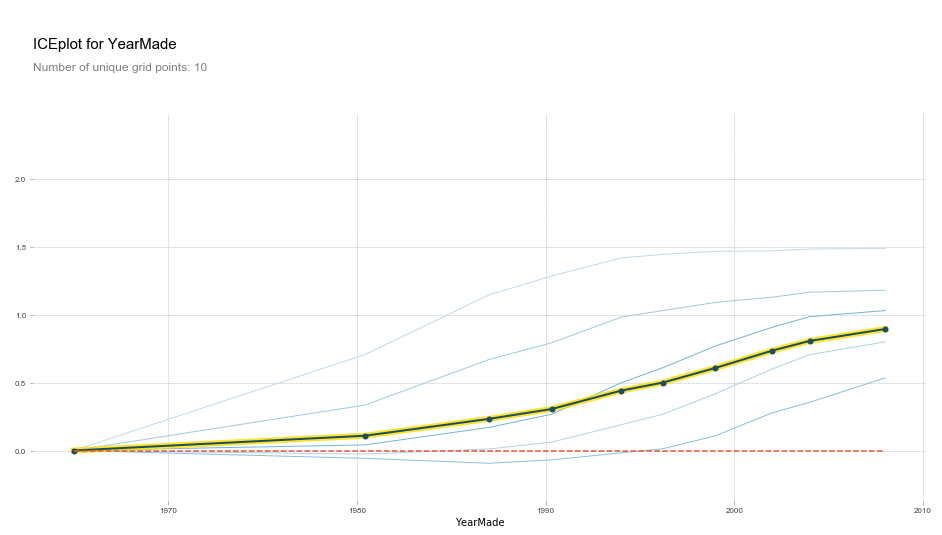

In [60]:
plot_pdp('YearMade', clusters=5)

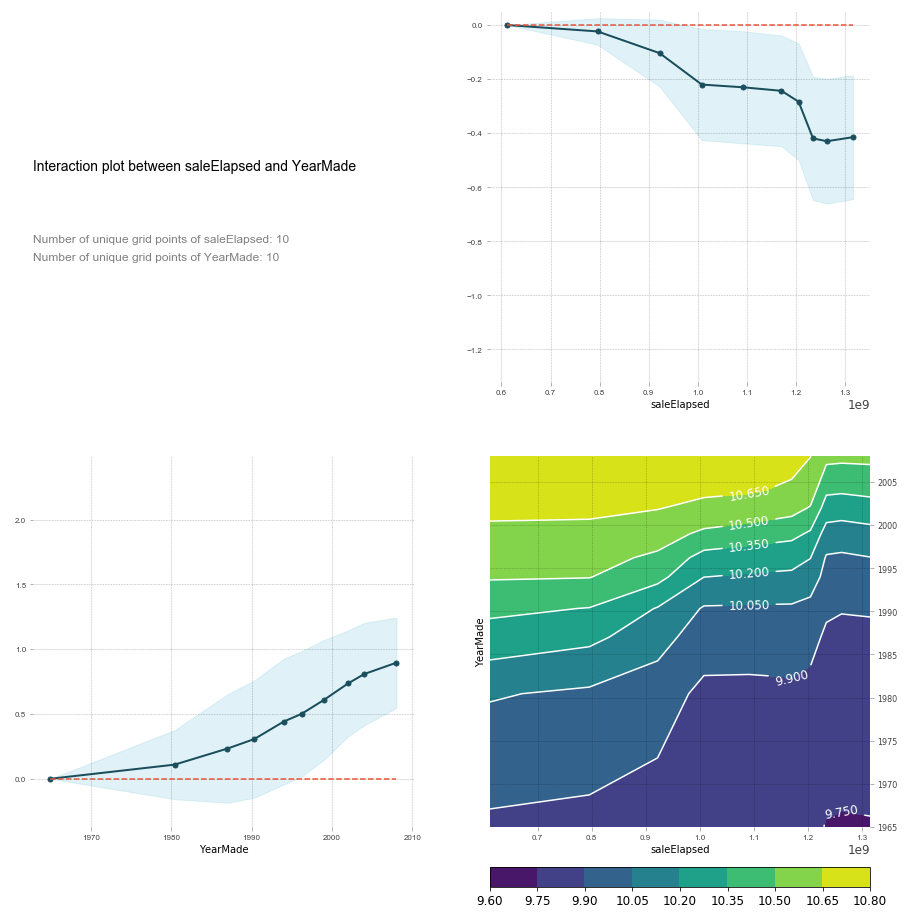

In [61]:
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x, feats)
pdp.pdp_interact_plot(p, feats)

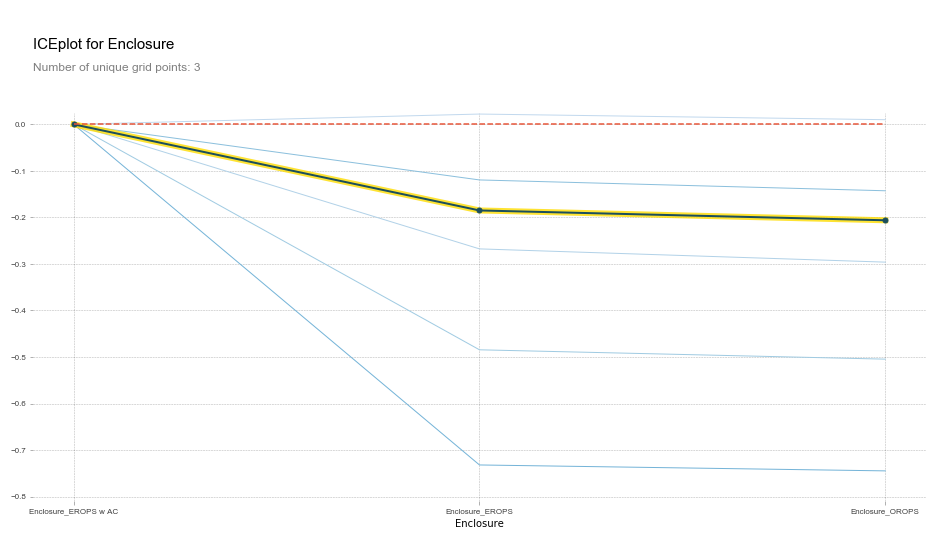

In [62]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')

In [63]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

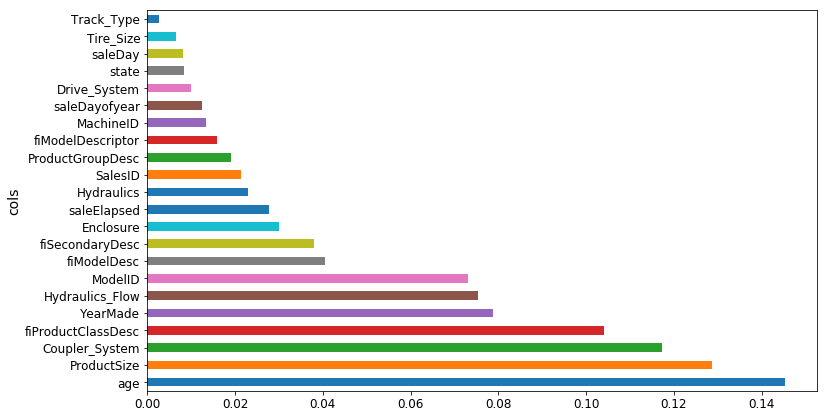

In [64]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep));

## Tree interpreter

In [66]:
from treeinterpreter import treeinterpreter as ti

In [67]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [68]:
row = X_valid.values[None,0]; row

array([[      1999,          0,          5,         17,        665, 1284595200,          0,          1,
                 0,       3232,          0,    4364751,    2300944,          4,         12,          0,
                 0,         35,         16,        259,          2,         11]])

In [69]:
prediction, bias, contributions = ti.predict(m, row)

In [70]:
prediction[0], bias[0]

(9.339742791703364, 10.105883095907192)

In [71]:
idxs = np.argsort(contributions[0])

In [72]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('ProductSize', 'Mini', -0.5937796819610409),
 ('age', 11, -0.16484927143113143),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -0.08391802788390387),
 ('fiModelDesc', 'KX1212', -0.061645320235402146),
 ('fiSecondaryDesc', nan, -0.05567454078165239),
 ('saleDayofyear', 259, -0.026564058585377203),
 ('Enclosure', 'EROPS', -0.02522220217461162),
 ('SalesID', 4364751, -0.020277028512325223),
 ('fiModelDescriptor', nan, -0.014761186619312828),
 ('saleElapsed', 1284595200, -0.01471035891927679),
 ('Tire_Size', nan, -0.006501865000464235),
 ('state', 'Ohio', -0.0015527418409679416),
 ('saleDay', 16, -0.0010172707200177377),
 ('Drive_System', nan, 0.0035375346755229576),
 ('Hydraulics', 'Standard', 0.01394363661087179),
 ('ProductGroupDesc', 'Track Excavators', 0.014488079768389062),
 ('Track_Type', 'Steel', 0.01610207519050775),
 ('ModelID', 665, 0.030168310888530846),
 ('Hydraulics_Flow', nan, 0.03675395819114282),
 ('MachineID', 2300944, 0.043413235425

In [73]:
contributions[0].sum()

-0.7661403042038271

## Extrapolation

In [74]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

In [75]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9999900280461202

In [76]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
11,SalesID,0.813860
5,saleElapsed,0.139488
12,MachineID,0.035455
0,YearMade,0.003293
4,ModelID,0.001751
19,saleDayofyear,0.001261
1,Coupler_System,0.001189
7,Enclosure,0.001120
9,fiModelDesc,0.001094
14,Hydraulics,0.000560


In [77]:
feats=['SalesID', 'saleElapsed', 'MachineID']

In [78]:
(X_train[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,389125.000000,3.891250e+05,389125.000000
mean,1800.452485,1.084797e+06,1206.796148
std,595.627288,1.803913e+05,430.850552
min,1139.246000,6.009984e+05,0.000000
25%,1413.348000,9.666432e+05,1087.016000
50%,1632.093000,1.134605e+06,1273.859000
75%,2210.453000,1.234138e+06,1458.661000
max,4364.741000,1.325117e+06,2313.821000


In [79]:
(X_valid[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,12000.000000,1.200000e+04,12000.000000
mean,5786.967651,1.306609e+06,1578.049709
std,836.899608,2.497808e+04,589.497173
min,4364.751000,1.174522e+06,0.830000
25%,4408.580750,1.309219e+06,1271.225250
50%,6272.538500,1.316045e+06,1825.317000
75%,6291.792250,1.321402e+06,1907.858000
max,6333.342000,1.325203e+06,2486.330000


In [80]:
x.drop(feats, axis=1, inplace=True)

In [81]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9788694297288875

In [82]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
18,age,0.236531
0,YearMade,0.185343
16,saleDayofyear,0.160266
4,ModelID,0.075477
8,fiModelDesc,0.062950
15,saleDay,0.058664
14,state,0.054436
3,fiProductClassDesc,0.033223
5,fiSecondaryDesc,0.023625
6,Enclosure,0.020805


In [83]:
set_rf_samples(50000)

In [84]:
feats=['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

In [85]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20760004392559253, 0.2489740914499211, 0.9099280203046309, 0.8892977911581024, 0.8933391731654539]


In [86]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

SalesID
[0.20899004420799128, 0.24537133098440814, 0.9087178161286178, 0.8924784264932245, 0.8926423087062384]
saleElapsed
[0.21416939018068773, 0.2550417627528933, 0.9041373067544973, 0.8838362624865489, 0.8870525845316091]
MachineID
[0.20706084452884008, 0.24783728645538072, 0.9103953004169356, 0.8903064062922628, 0.894717384227918]
age
[0.2091309151496703, 0.24716360027642176, 0.9085947160920289, 0.8909019471862948, 0.8920758260894018]
YearMade
[0.20927431435035482, 0.2526942886302706, 0.908469321542206, 0.8859648268590136, 0.8919524195435133]
saleDayofyear
[0.20884860143537645, 0.24389756652336786, 0.908841332405447, 0.8937661530800609, 0.892822572089926]


In [87]:
reset_rf_samples()

In [88]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.13846079369890865, 0.21825445830379814, 0.9599328492843473, 0.9149304331180135, 0.9092146918087662]


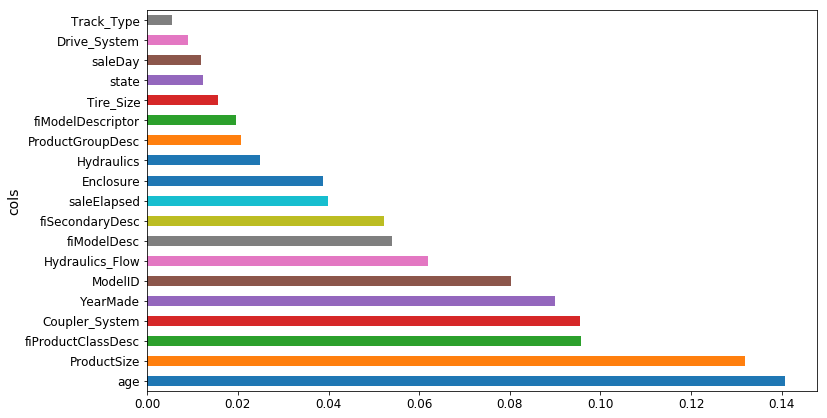

In [89]:
plot_fi(rf_feat_importance(m, X_train));

In [90]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

## Our final model!

In [ ]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 6min 30s, sys: 24 s, total: 6min 54s
Wall time: 3min 57s
